In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.signal import savgol_filter
import pickle
import keras_tuner as kt

import IPython
import IPython.display

# Read in Processed Data

## Kalman Filtering

In [5]:
def filter_data(input_data):
    output = input_data.copy()
    filtered = savgol_filter(output['GlucoseLevel'], 7, 3)
    output['GlucoseLevel'] = filtered
    return output

In [6]:
datapath = '../../OhioT1DM/data/processed/'
train_563 = pd.read_csv(datapath + 'train_563.csv').set_index('ts')
train_588 = pd.read_csv(datapath + 'train_588.csv').set_index('ts')
train_570 = pd.read_csv(datapath + 'train_570.csv').set_index('ts')

test_563 = pd.read_csv(datapath + 'test_563.csv').set_index('ts')
test_588 = pd.read_csv(datapath + 'test_588.csv').set_index('ts')
test_570 = pd.read_csv(datapath + 'test_570.csv').set_index('ts')

In [7]:
all_train_data = [train_563, train_588, train_570]
all_test_data = [test_563, test_588, test_570]
all_filtered_data = [filter_data(x) for x in all_train_data]
patient_names = {0: '563', 1: '588', 2: '570'}

In [8]:
compartmentals = ['Short', 'Long', 'Carb']

[]

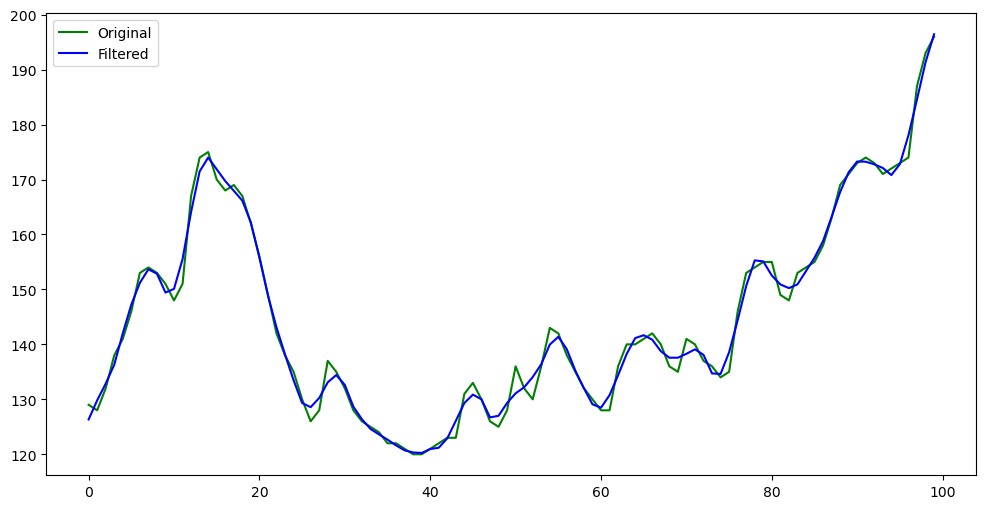

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(list(range(100)), all_train_data[0]['GlucoseLevel'][100:200], c='g', label='Original')
plt.plot(list(range(100)), all_filtered_data[0]['GlucoseLevel'][100:200], c='b', label='Filtered')
plt.legend()
plt.plot()

# Setup Window Slicing Code

In [10]:
class PredictionRangeGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, test_df, label_columns=None, batch_size=32):
        
        self.batch_size = batch_size
        
        # Store data in Generator
        self.train_df = train_df
        self.test_df = test_df
        
        #Work out column indices for different labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:,:, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
            
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
            
        return inputs, labels
    
    def plot(self, model=None, plot_col='GlucoseLevel', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 2*max_subplots))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10, c='#00008B')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        label='Actual', c='#90EE90', edgecolors='k', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          label='Predicted',
                          marker='X', c='#808080', edgecolors='k', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [index]')
        
        
    def make_dataset(self, data, shuffle):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=self.batch_size,)
        
        ds = ds.map(self.split_window)
        
        return ds
        
    @property
    def train(self):
        return self.make_dataset(self.train_df, True)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df, False)
    
    @property
    def example(self):
        """Get and cache an example batch for plotting"""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch found, so get one from train df
            result = next(iter(self.train))
            self._example = result
        return result

# Setup a Baseline to Test Prediction Against

In [11]:
class LinearBaseline(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        """
        Simply returns last value as next value
        """
        return inputs[:, -1, tf.newaxis]

In [13]:
linear_base = LinearBaseline()
linear_base.compile(loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.RootMeanSquaredError()],)

# Setup Windows to be Predicted Over

In [14]:
PREV = 6

In [15]:
fifteen_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 3,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

thirty_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 6,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

sixty_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 12,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

def create_range(shift, train, test, prev=PREV):
    return PredictionRangeGenerator(
        input_width = PREV,
        label_width = 1,
        shift = shift,
        label_columns=['GlucoseLevel'],
        train_df=train,
        test_df=test
    )

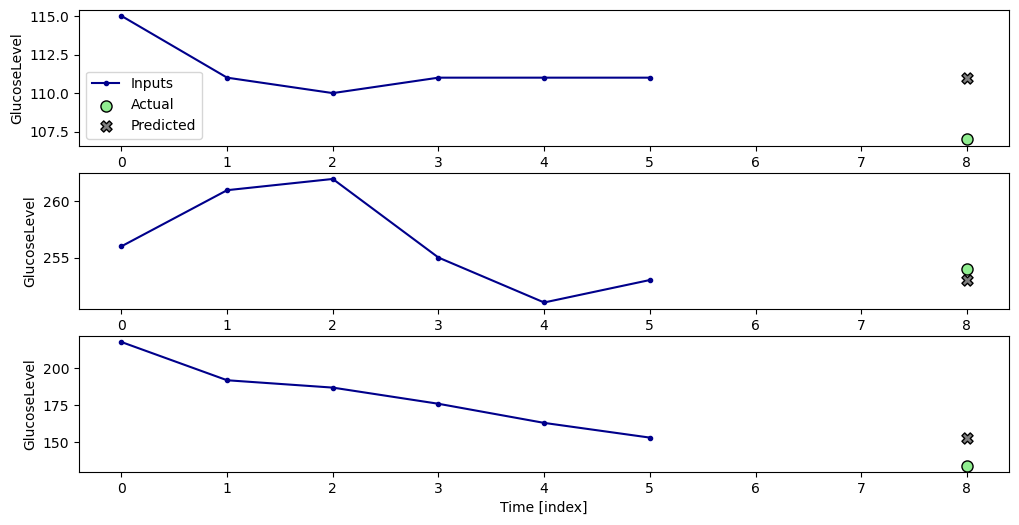

In [16]:
fifteen_range_g.plot(linear_base)

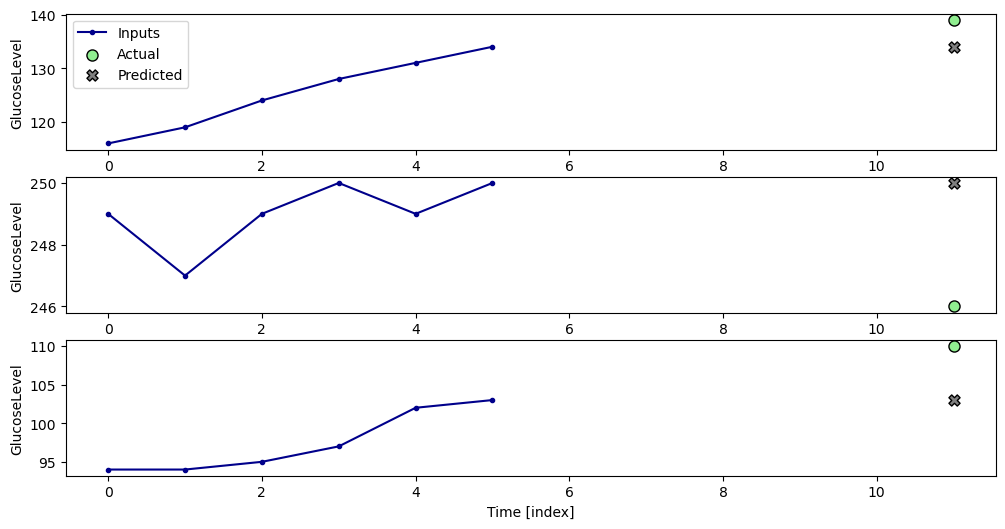

In [17]:
thirty_range_g.plot(linear_base)

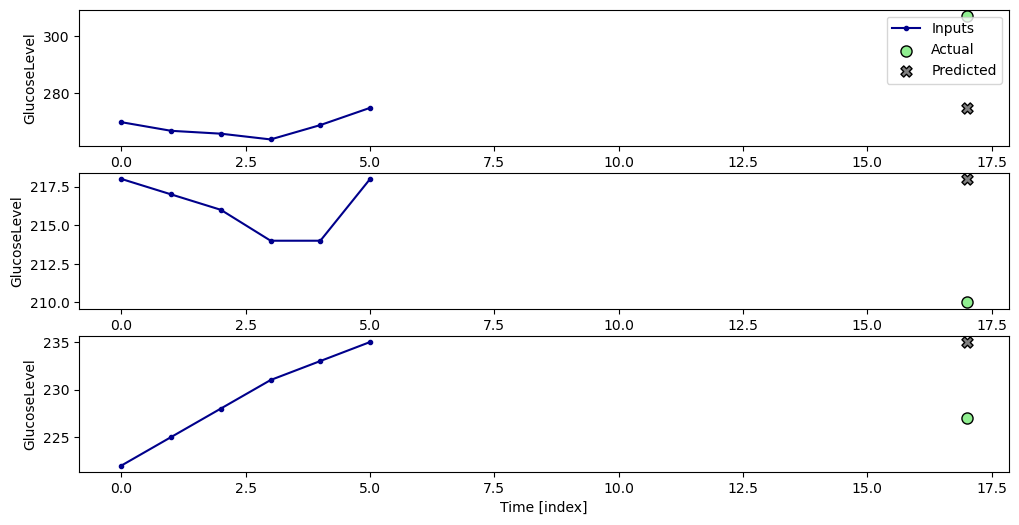

In [18]:
sixty_range_g.plot(linear_base)

# Setup Model Training Code

In [19]:
# Setup function to train model on training data

def fit_model(model, predict_range, lr=0.01, MAX_EPOCHS=20):
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError()])

    model_history = model.fit(predict_range.train, epochs=MAX_EPOCHS)
    return model_history

In [20]:
def plot_model_predictions(model, pred_range, num_graphs=3):
    all_inputs = np.concatenate([x for x,y  in pred_range.test], axis=0)
    all_labels = np.concatenate([y for x,y in pred_range.test], axis=0)
    size = len(all_inputs)
    graph_size = size // num_graphs
    index = 0
    for i in range(num_graphs):
        cur_slice = slice(index, index+graph_size)
        if i == (num_graphs - 1):
            cur_slice = slice(index, size)
        cur_inputs = all_inputs[cur_slice]
        cur_labels = all_labels[cur_slice][:,0]
        print(cur_labels.shape)
        index += graph_size
        predictions = model(cur_inputs)[:,0,tf.newaxis]
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(list(range(len(predictions.numpy()))), predictions.numpy().reshape(-1), 'g', linestyle='dashed', label='Predicted')
        plt.plot(list(range(len(cur_labels))), cur_labels.reshape(-1), '-', label='Actual')
        plt.legend()
        plt.show()
    

In [21]:
def train_and_test_model(model, train, test, shift, previous=PREV, epochs=40):
    print("Running for Range: {} mins\n".format(shift*5))
    pred_range = create_range(shift, train, test, previous)
    fit_model(model, pred_range, epochs)
    IPython.display.clear_output()
    train_acc = model.evaluate(pred_range.train)
    test_acc = model.evaluate(pred_range.test)
    print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}\n".format(train_acc[1], test_acc[1]))
    return train_acc[1], test_acc[1], model

In [22]:
def save_result(result, path):
    f = open(path, "wb")
    pickle.dump(result, f)
    f.close()

def glucose_input_only(input_data):
    return pd.DataFrame(input_data['GlucoseLevel'])
    
def add_to_dict(dictionary, key, value):
    if key in dictionary:
        dictionary[key].append(value)
    else:
        dictionary[key] = [value]
    return dictionary

def run_experiment(training, testing, ranges, previous, epochs, create_model, filepath, glucose=False, num_out=1):
    accs = {}
    models = {}
    for i in range(len(training)):
        for j in range(len(ranges)):
            name = patient_names[i]
            print("Running for Patient {}\n".format(name))
            cur_train = glucose_input_only(training[i]) if glucose else training[i]
            cur_test = glucose_input_only(testing[i]) if glucose else testing[i]
            shift = ranges[j]
            prev = previous[j]
            epoch = epochs[j]
            train_acc, test_acc, model = train_and_test_model(create_model(num_out),
                                                      cur_train,
                                                      cur_test,
                                                      shift,
                                                      prev,
                                                      epoch)        
            accs = add_to_dict(accs, name, [train_acc, test_acc])
            models = add_to_dict(models, name, model)
        save_result(accs, filepath)
    return accs, models

# Experiment with Different models

## 1. LSTM RNN with CGM Data

### 1.1 Filtered vs Unfiltered Data, Residual vs Non-Residual

In [23]:
class ChangeLayer(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def call(self, inputs, *args, **kwargs):
        change = self.model(inputs, *args, **kwargs)
        return inputs + change
        

In [24]:
def create_normal_lstm(output_length, num_units=128):
    return tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
    tf.keras.layers.Reshape([output_length, 1])
    ])

def create_change_lstm(output_length, num_units=128):
    return ChangeLayer(
        tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
        tf.keras.layers.Reshape([output_length, 1])
        ])
    )

In [25]:
lstm = create_normal_lstm(1)

In [26]:
change_lstm = create_change_lstm(1)

In [27]:
print("Input shape: ", thirty_range_g.example[0].shape)
print('Output shape:', change_lstm(thirty_range_g.example[0]).shape)

Input shape:  (32, 6, 1)
Output shape: (32, 6, 1)


In [28]:
print("Input shape: ", fifteen_range_g.example[0].shape)
print('Output shape:', lstm(fifteen_range_g.example[0]).shape)

Input shape:  (32, 6, 1)
Output shape: (32, 1, 1)


In [29]:
ranges = [3,6,12]
previous = [PREV]*3
epochs = [25]*3

In [30]:
# accs_norm, models_norm = run_experiment(all_filtered_data,
#                                                    all_test_data,
#                                                    ranges, previous, epochs,
#                                                    create_normal_lstm, 'filteredNorm.pkl', glucose=True)

## Tune hyperparams for unfiltered

In [31]:
def get_all_inputs_and_labels(pred_range):
    all_inputs = np.concatenate([x for x,y  in pred_range.train], axis=0)
    all_labels = np.concatenate([y for x,y in pred_range.train], axis=0)
    return all_inputs, all_labels
    
def build_lstm_model(hp):
    hp_units = hp.Int('lstm_units', min_value=32, max_value=512, step=64)
    
    hp_lr = hp.Choice('lr', values=[1e-2,1e-3,])
    
    model = create_normal_lstm(1, num_units=hp_units)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model


In [32]:
tuner = kt.Hyperband(build_lstm_model, max_epochs=40, objective='loss', factor=3, directory='tuning', project_name='BGNorm15570', overwrite=True)

In [33]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [34]:
inp, lab = get_all_inputs_and_labels(thirty_range_g)
tuner.search(fifteen_range_g.train, epochs=40, callbacks=[stop_early])

Trial 90 Complete [00h 03m 02s]
loss: 119.3729248046875

Best loss So Far: 119.3729248046875
Total elapsed time: 01h 06m 43s
INFO:tensorflow:Oracle triggered exit


In [139]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [144]:
print(best_hps.get('lr'))
print(best_hps.get('lstm_units'))

0.001
224


In [140]:
model = tuner.hypermodel.build(best_hps)

In [141]:
history = model.fit(thirty_range_g.train, epochs=50,)
val_acc_per_epoch = history.history['loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/50
343/343 [==============================] - 5s 10ms/step - loss: 24005.0820 - root_mean_squared_error: 154.9357
Epoch 2/50
343/343 [==============================] - 4s 10ms/step - loss: 9796.7920 - root_mean_squared_error: 98.9787
Epoch 3/50
343/343 [==============================] - 3s 10ms/step - loss: 4491.0122 - root_mean_squared_error: 67.0150
Epoch 4/50
343/343 [==============================] - 4s 10ms/step - loss: 2292.1694 - root_mean_squared_error: 47.8766
Epoch 5/50
343/343 [==============================] - 3s 10ms/step - loss: 1364.5302 - root_mean_squared_error: 36.9395
Epoch 6/50
343/343 [==============================] - 4s 11ms/step - loss: 927.8574 - root_mean_squared_error: 30.4608
Epoch 7/50
343/343 [==============================] - 4s 10ms/step - loss: 693.4298 - root_mean_squared_error: 26.3331
Epoch 8/50
343/343 [==============================] - 3s 10ms/step - loss: 581.0262 - root_mean_squared_error: 24.1045
Epoch 9/50
343/343 [=====================

KeyboardInterrupt: 

In [319]:
num_epochs = 33

In [320]:
hypermodel = tuner.hypermodel.build(best_hps)

In [325]:
model.fit(inp, lab, epochs=num_epochs)

Epoch 1/33
86/86 [==============================] - 2s 5ms/step - loss: 34466.6797 - root_mean_squared_error: 185.6520 - mean_absolute_error: 171.1123
Epoch 2/33
86/86 [==============================] - 1s 6ms/step - loss: 12473.1943 - root_mean_squared_error: 111.6835 - mean_absolute_error: 95.4683
Epoch 3/33
86/86 [==============================] - 1s 6ms/step - loss: 5866.5781 - root_mean_squared_error: 76.5936 - mean_absolute_error: 64.0229
Epoch 4/33
86/86 [==============================] - 1s 6ms/step - loss: 3055.6836 - root_mean_squared_error: 55.2783 - mean_absolute_error: 42.3993
Epoch 5/33
86/86 [==============================] - 0s 5ms/step - loss: 1515.6099 - root_mean_squared_error: 38.9308 - mean_absolute_error: 28.1100
Epoch 6/33
86/86 [==============================] - 1s 6ms/step - loss: 981.5356 - root_mean_squared_error: 31.3295 - mean_absolute_error: 22.2181
Epoch 7/33
86/86 [==============================] - 1s 6ms/step - loss: 770.1450 - root_mean_squared_error: 

In [143]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 224)               202496    
                                                                 
 dense_1 (Dense)             (None, 1)                 225       
                                                                 
 reshape_1 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 202,721
Trainable params: 202,721
Non-trainable params: 0
_________________________________________________________________


In [142]:
model.evaluate(thirty_range_g.test)

86/86 [==============================] - 1s 4ms/step - loss: 308.8792 - root_mean_squared_error: 17.5750


[308.879150390625, 17.57495880126953]

In [120]:
lstm = create_normal_lstm(1)

In [122]:
lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError()])

lstm_history = lstm.fit(inp,lab, epochs=20)

Epoch 1/20
343/343 [==============================] - 3s 5ms/step - loss: 29179.4648 - root_mean_squared_error: 170.8200 - mean_absolute_error: 158.2783
Epoch 2/20
343/343 [==============================] - 2s 5ms/step - loss: 17410.3711 - root_mean_squared_error: 131.9484 - mean_absolute_error: 116.3625
Epoch 3/20
343/343 [==============================] - 2s 5ms/step - loss: 10992.5898 - root_mean_squared_error: 104.8456 - mean_absolute_error: 88.3977
Epoch 4/20
343/343 [==============================] - 2s 5ms/step - loss: 7251.6650 - root_mean_squared_error: 85.1567 - mean_absolute_error: 70.3457
Epoch 5/20
343/343 [==============================] - 2s 5ms/step - loss: 5253.3545 - root_mean_squared_error: 72.4800 - mean_absolute_error: 59.5659
Epoch 6/20
343/343 [==============================] - 2s 5ms/step - loss: 4359.2334 - root_mean_squared_error: 66.0245 - mean_absolute_error: 54.2794
Epoch 7/20
343/343 [==============================] - 2s 5ms/step - loss: 4016.3608 - root_m

KeyboardInterrupt: 